In [57]:
# General Imports
import numpy as np
import pandas as pd
import csv
import time
import os
from datetime import datetime as dtime
import re


# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 15,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn, scipy
from sklearn.model_selection import train_test_split
from scipy.stats import unitary_group

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Global definitions

In [58]:
# Number of qubits in considered system
# Dimension of Hilbert space is 2 ** NQ
# Total independent parameters in state density matrix is 4**NQ -1

NQ = 1
state_gen_method = 'random_uniform_vector'

assert state_gen_method in ['unitary_column', 'random_uniform_vector']

In [59]:
# State Visualization

def plot_dm(astate, title='', save_path=False, fixed_scale=False):

    # Make square matrix
    if len(astate.shape) == 1:
        dim = int(np.sqrt(len(astate)))
        astate = astate.reshape(dim, dim)
    else:
        dim = len(astate)

    # Init arrays
    dz = astate.ravel()
    xpos, ypos = np.meshgrid(np.arange(dim), np.arange(dim))
    xpos = xpos.ravel()
    ypos = ypos.ravel()


    fig = plt.figure(dpi=80)

    # Optionally setting scale
    if fixed_scale:
        vmin, vmax = fixed_scale
    else:
        vmin=min(dz)
        vmax=max(dz)

    # Init colorbar
    cmap = cm.get_cmap('plasma')
    norm = Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(dz))

    # 2D color plot
    ax = fig.add_subplot(5,7,(12,28))
    ax.imshow(astate, vmin=vmin, vmax=vmax, cmap=cmap)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    a=sc.set_array([])
    a=plt.colorbar(sc)


    # Classical 3D density matrix plot
    ax = fig.add_subplot(5,7,(1,32), projection='3d')
    a=ax.bar3d(x=xpos-.25, y=ypos-.25, z=0, dx=0.5, dy=0.5, dz=dz, color=colors)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=ax.set_zticks([])
    a=ax.set_zlim(-max(dz), max(dz))
    a=ax.grid(False)
    #Plot grid on z=0
    for i in range(dim):
        a=ax.plot(i*np.ones(dim), np.arange(dim), 0, color='k', lw=.5)
        a=ax.plot(np.arange(dim), i*np.ones(dim), 0, color='k', lw=.5)

    if title != '':
        fig.suptitle(title)

    if save_path: plt.savefig(save_path, dpi=120)

    plt.show()

# State Generator

## Pure states

In [60]:
if state_gen_method == 'unitary_column':
    # Adapted for vector from unitary group
    def create_pure_rho(nqubits):
        dim = 2**nqubits
        psi = unitary_group.rvs(dim)[0]
        # psi =   np.random.uniform(low=-1, high=1, size=dim) + 1j * np.random.uniform(low=-1, high=1, size=dim) 
        rho = np.outer(psi, psi.T.conjugate())
        
        #Positive-definiteness given due to outer product above
        # Trace condition
        rho /= np.trace(rho)
        
        return rho

if state_gen_method == 'random_uniform_vector':
    ### Random number states
    def create_pure_rho(nqubits):
        dim = 2**nqubits
        psi =   np.random.uniform(low=-1, high=1, size=dim) +\
                1j * np.random.uniform(low=-1, high=1, size=dim) 
        rho = np.outer(psi, psi.T.conjugate())

        # Trace condition
        rho /= np.trace(rho)

        # Positive semi-definiteness condition
        if not np.all(np.linalg.eigvals(rho) >= -1e-10):
            # print('recursive')
            return create_pure_rho(nqubits)
        return rho

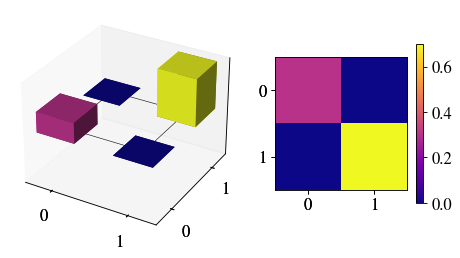

In [61]:
plot_dm(np.array([[0.3,0],[0,0.7]]), save_path='/Users/canrager/thesis/results/just-a-qubit.png')

In [62]:
# Test Trace nqubits = NQ
n = 100
print('Traces of 100 test 1qubit states squared = 1?')
traces = np.array([create_pure_rho(nqubits=NQ) for _ in range(n)])
traces = np.array([np.trace(np.real(rho.dot(rho))) for rho in traces])
np.all( (traces-1) < 1e-10 )

Traces of 100 test 1qubit states squared = 1?


True

## Mixed States

### Partial trace method

In [63]:
def partial_trace(rho):
    dim = 2**NQ
    reduced = np.zeros((dim,dim), dtype=np.complex128)
    for bvec in np.eye(dim):
        bra = np.kron(np.eye(dim), bvec)
        reduced += bra.dot(rho.dot(bra.T))
    return reduced

# Wrapper function
def random_rho(pure):
    if pure:
        return create_pure_rho(nqubits=NQ)
    else:
        return partial_trace(create_pure_rho(nqubits=NQ*2))

(1+0j)

(0.92+0j)

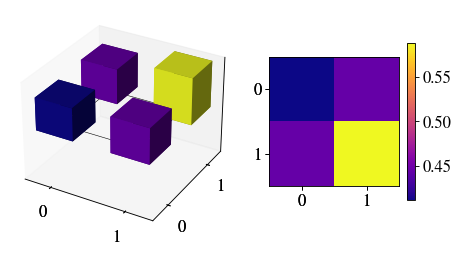

In [64]:
#Test
astate = random_rho(pure=False)
# Tr(rho)
np.round(np.trace(astate),2)
# Tr(rho^2)
np.round(np.trace(astate.dot(astate)),2)
plot_dm(np.real(astate))

### Bloch vector method

In [65]:
# # Pauli matrices
# s1 = np.array([[0,1],[1,0]])
# s2 = np.array([[0,-1j],[1j,0]])
# s3 = np.array([[1,0],[0,-1]])

# pauli_matrices = np.array([s1, s2, s3])

# def random_bloch(pure):
#     if pure:
#         r = 1
#     else:
#         r = np.random.uniform(low=0, high=1)
#     phi, theta = np.random.uniform(low=0, high=1, size=2)
#     phi *= 2*np.pi
#     theta *= np.pi
#     return r * np.array([   np.cos(phi)*np.sin(theta),
#                             np.sin(phi)*np.sin(theta),
#                             np.cos(theta)
#                         ])

# def bloch2mat(vec):
#     assert vec.shape[0] == 3
#     r_sig = vec[0] * s1 + vec[1] * s2 + vec[2] * s3
#     return np.array((np.eye(2) + r_sig) /2)

# def mat2bloch(rho):
#     x = np.trace(rho.dot(s1))
#     y = np.trace(rho.dot(s2))
#     z = np.trace(rho.dot(s3))
#     return np.real(np.array([x, y, z]))


# # Testing
# print("Pure state")
# test_1q = random_bloch(pure=True)
# test_1q
# np.linalg.norm(test_1q)
# plot_dm(np.real(bloch2mat(test_1q)))

# print("Mixed state")
# test_1q = random_bloch(pure=False)
# test_1q
# np.linalg.norm(test_1q)
# plot_dm(np.real(bloch2mat(test_1q)))

# print('bloch2mat2bloch')
# test_1q
# mat2bloch(bloch2mat(test_1q))

## Trace Distributions

### Mixed states from partial trace

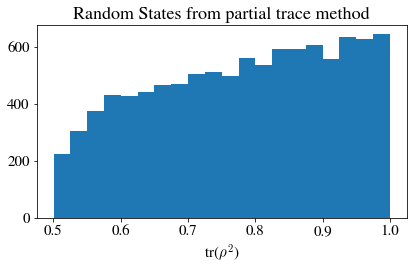

In [66]:
n = 10000
traces = np.array([random_rho(pure=False) for _ in range(n)])
traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
a=plt.hist(np.real(traces), bins=20)
a=plt.xlabel('tr($\\rho^2$)')
a=plt.title('Random States from partial trace method')

# if NQ == 1:
#     n = 10000
#     traces = np.array([bloch2mat(random_bloch(pure=False)) for _ in range(n)])
#     traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
#     a=plt.hist(np.real(traces), bins=20)
#     a=plt.xlabel('tr($\\rho^2$)')
#     a=plt.title('Random States from bloch vector method')

In [67]:
# Retrieve independent values from density matrix

## Treat complex numbers as 2 independent floating numbers for processing in network
## Processing complex units is not yet implemented to pytorch

def rho2torch(rho):
    dim = 2**NQ
    rho = rho.reshape(dim, dim)
    diags = np.array([np.real(rho[i,i]) for i in range(dim-1)])
    ur = np.array([])
    for i in range(dim-1):
        ur = np.hstack((ur, rho[i][i+1:dim]))
    ur = np.hstack((np.real(ur), np.imag(ur)))
    return np.hstack((diags, ur))

def torch2rho(tensor):
    dim = 2**NQ
    diag_coeff = np.array(tensor[:dim-1])
    norm_coeff = 1 - np.sum(diag_coeff)
    diags = np.hstack((diag_coeff, norm_coeff))
    diags = np.diag(diags)

    num_ur_entries = np.sum(np.arange(dim))
    ur_real = tensor[dim-1:dim-1+num_ur_entries]
    ur_imag = tensor[dim-1+num_ur_entries:]

    ur = np.zeros((dim,dim), dtype='complex64')
    for i in range(num_ur_entries):
        for j in range(i+1, dim):
            ur[i,j] = ur_real[0] + 1.j* ur_imag[0]
            ur_real = np.delete(ur_real, 0)
            ur_imag = np.delete(ur_imag, 0)
    return diags + ur + ur.T.conjugate()

# Test
astate = np.round(random_rho(pure=False), NQ)
bstate = torch2rho(rho2torch(astate))

print("Do rho and rho2torch2rho coincide?")
np.all((astate - bstate) < 1e10)

Do rho and rho2torch2rho coincide?


True

# Measurement
using random states generated by partial trace method

## Create random set of observables

Goal: overcomplete measurements that allow full determination of rho from random observables

In [68]:
def create_random_obs(pure, n=100):
    return np.array([random_rho(pure=pure) for _ in range(n)])

def perform_measurements(rho, observables):
    return np.real( np.trace(observables.dot(rho), axis1=1, axis2=2) )

mean = 0.49958648332732863
std = 0.0677373205314736


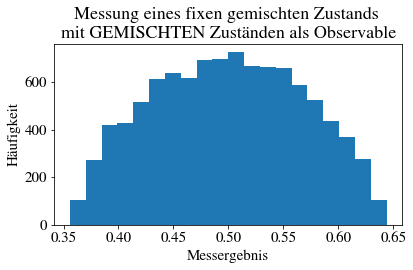

In [69]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=False, n=10000)

meas = perform_measurements(base_state, observables)
print('mean =', meas.mean())
print('std =', meas.std())

a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit GEMISCHTEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')
#a=plt.xlim(0,1)

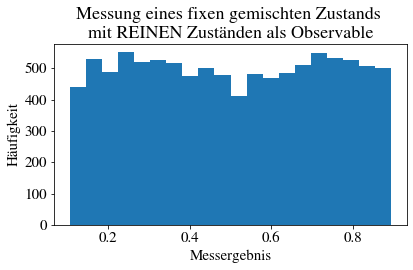

In [70]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=True, n=10000)

meas = perform_measurements(base_state, observables)


a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit REINEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')

## Create Dataset

with same observables!

In [71]:
# Set parameters for new dataset
n_states = int(5e4)
exp_title = 'tomo0607'
obs_arr = [15]

In [72]:
# # Generate folders
# experiment_name = exp_title + f'_{NQ}qubit_'+ state_gen_method
# if not os.path.isdir('./data/' + experiment_name):
#     os.mkdir('./data/' + experiment_name)

# for nobs in tqdm(obs_arr):
#   for _ in range(10):
#     n_observables = nobs
#     observables = create_random_obs(pure=True, n=n_observables)
#     states = np.array([random_rho(pure=False) for _ in range(n_states)])
#     states_freeparams = np.array([rho2torch(rho) for rho in states])    # Reduce rho to free parameters


#     # Write out dataset

#     timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
#     PARENTPATH = f"./data/"+ experiment_name + f'/states{n_states}_obs{n_observables}/'
#     DATAPATH = PARENTPATH+f"run_{timestamp}/"
#     if not os.path.isdir(PARENTPATH):
#       os.mkdir(PARENTPATH)
#     os.mkdir(DATAPATH)

#     # Write out states
#     with open(DATAPATH + 'states_freeparams.csv', 'w') as f:
#       writer = csv.writer(f)
#       for state in tqdm(states_freeparams):
#         a=writer.writerow(state)
        
#     # Write out observables
#     with open(DATAPATH + 'observables.csv', 'w') as f:
#       writer = csv.writer(f)
#       for obs in tqdm(observables):
#         a=writer.writerow(obs.reshape(4**(NQ)))

#     # Write out measurements 
#     with open(DATAPATH + 'measurements.csv', 'w') as f:
#       writer = csv.writer(f)
#       for state in tqdm(states):
#         a=writer.writerow(perform_measurements(state, observables))

#     # Wait a sec so the next dataset gets a new name
#     time.sleep(1)



# FFN Tomography

### Prepare dataset

In [73]:
class QuantumMeasurementDataset(Dataset):
    def __init__(self, root_dir):
        self.measurements_frame = pd.read_csv(root_dir + 'measurements.csv', header=None)
        self.states_frame = pd.read_csv(root_dir + 'states_freeparams.csv', header=None)

    def __len__(self):
        return len(self.states_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        measurement = self.measurements_frame.iloc[idx]
        measurement = np.array(measurement).astype('float')
        measurement = torch.Tensor(measurement)

        state = self.states_frame.iloc[idx]
        state = np.array(state).astype('float')
        state = torch.Tensor(state)

        return measurement, state


In [74]:
def load_dataset(datadir, nstat, BATCH_SIZE = 64, splits = np.array([0.8, 0.1, 0.1])):
    # Train_valid_treasure split
    assert np.sum(splits) == 1

    tomography_dataset = QuantumMeasurementDataset(root_dir=datadir)
    tomography_train_dataset, tomography_valid_dataset, tomography_treasure_dataset = torch.utils.data.random_split(\
        tomography_dataset, (nstat*splits).astype(int), generator=torch.Generator().manual_seed(42))

    # Create data loaders from the datasets for the current task
    # Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
    tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_valid_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_treasure_dataloader = DataLoader(tomography_treasure_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    return tomography_train_dataloader, tomography_valid_dataloader, tomography_treasure_dataloader 

## Feed Forward Network

Measurement outcomes --> bloch representation of state

In [75]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [76]:
class FeedForwardNet(nn.Module):

  def __init__(self, n_obs):
    super().__init__()

    self.dof = 4**NQ - 1
    self.layer_sizes = [n_obs, 64, 32]
    
    self.layers = nn.Sequential(
    nn.Linear(self.layer_sizes[0], self.layer_sizes[1]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[1], self.layer_sizes[2]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[2], self.dof),
    )

  def forward(self, x):
    return self.layers(x)

## Training

In [77]:
def evaluate_mse_ffn(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements, target = batch[0].to(device), batch[1].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, target).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [78]:
# Function for training the network
def train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ffn(net, valid_dataloader, criterion, device))
    return train_losses, valid_losses

In [79]:
def plot_train_stats(train_losses, valid_losses, it_per_epoch, path):
    a=plt.figure(figsize=(10,4))
    a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/train_losses.png', dpi=150)
    plt.show()

    a=plt.figure(figsize=(10,4))
    a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/valid_losses.png', dpi=150)
    plt.show()

In [80]:
def ffn_wrapper(data_dir, model_title, nstat, nobs, nepochs, learning_rate, batch_size, splits = np.array([0.8, 0.1, 0.1])):
    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)
    tomography_train_dataloader, tomography_valid_dataloader, _ = load_dataset(data_dir, nstat, batch_size, splits)

    # Create the network on the CPU/GPU
    net = FeedForwardNet(n_obs=nobs).to(device)
    print(net)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Perform Training
    train_losses, valid_losses = train(net, nepochs, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

    # Save Model
    path = f'./models/FFN_states{int(nstat)}_obs{nobs}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(tomography_train_dataloader), path=path)


In [81]:
def train_multiple_runs(dataexp_path, model_title, nstat, obs_arr, bs, lr, nepochs):
    hyperparameter_dir = [f'states{int(nstat)}_obs{n_obs}' for n_obs in obs_arr]
    for nobs, hdir in zip(obs_arr, hyperparameter_dir):
        hpath = dataexp_path + '/' + hdir
        run_directories = [f for f in os.listdir(hpath) if os.path.isdir(os.path.join(hpath, f))]
        for rdir in run_directories:
            run_path = hpath + '/' + rdir + '/'
            ffn_wrapper(data_dir = run_path,
                        model_title=model_title,
                        nstat=nstat,
                        nobs=nobs,
                        nepochs=nepochs,
                        learning_rate=lr, 
                        batch_size=bs, 
                        splits = np.array([0.8, 0.1, 0.1]))

In [82]:
# 2 Qubits Test

# ffn_wrapper(data_dir='./data/tomo0607_2qubit_random_uniform_vector/states50000_obs15/run_20220609_123504/',
#             model_title='2qubit_ConstLatentDim',
#             nstat=5e4,
#             nobs=15,
#             nepochs=10,
#             learning_rate=1e-2,
#             batch_size=128,
#             splits=np.array([0.8, 0.1, 0.1]))

In [83]:
# train_multiple_runs(dataexp_path='./data/tomo0607_2qubit_random_uniform_vector',
#                     model_title='ConstLatentDimension',
#                     nstat=int(1e4), 
#                     obs_arr=np.array([12, 15, 20]), 
#                     bs=64,
#                     lr=1e-3,
#                     nepochs=15)

## Evaluation

performance on unseen data (treasure set)

comparison between untrained and trained net

### Single Model


In [84]:
nstat = int(1e4)
nobs = 3
model_path = './models/FFN_states10000_obs3_epochs1_lr0.001_ConstLatentDimension_run_20220604_092932'
data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs3/run_20220604_092923'

In [85]:
load_net = FeedForwardNet(n_obs=nobs).to(device)
load_net.load_state_dict(torch.load(model_path+'/model.model'))
_, _, tomography_treasure_dataloader = load_dataset(datadir=data_path+'/', nstat=nstat)

print('Mean Square Error of on unseen data')
untrained_net = FeedForwardNet(n_obs=nobs).to(device)
print('Untrained Net: ', evaluate_mse_ffn(
    untrained_net, tomography_treasure_dataloader,nn.MSELoss(),device))
print('Trained Net: ', evaluate_mse_ffn(
    load_net, tomography_treasure_dataloader, nn.MSELoss(), device))

FileNotFoundError: [Errno 2] No such file or directory: './models/FFN_states10000_obs3_epochs1_lr0.001_ConstLatentDimension_run_20220604_092932/model.model'

### Evaluate Multiple
Load trained models for different numbers of observables and evaluate their error on the ```tomography_treasure_dataloader```

model_performance -> run performance -> performances

In [86]:
def treasure_evaluation(nobservables, model_path, dataloader):
    load_net = FeedForwardNet(n_obs=nobservables).to(device)
    load_net.load_state_dict(torch.load(model_path+'/model.model'))

    return evaluate_mse_ffn(load_net, dataloader, nn.MSELoss(), device)

def evaluate_multiple(dataexp_path, model_title, nstat, obs_arr, num_runs, return_run_names=False):

    performances = np.zeros((0, num_runs))
    run_names = np.array([])
    all_model_names = [f for f in os.listdir('./models') if model_title in f]
    for nobs in obs_arr:
        run_perf = np.array([])
        obs_model_names = [f for f in all_model_names if (f'obs{nobs}_' in f)]
        for mn in obs_model_names:
            model_path = './models/' + mn
            run_name = re.search('([^(run)]+$)', model_path).group(0)
            run_names = np.append(run_names, 'run'+run_name)
            data_path = dataexp_path + f'/states{int(nstat)}_obs{nobs}/run{run_name}/'
            try:
                _,_,treasure_dataloader = load_dataset(datadir=data_path, nstat=nstat)
                model_perf = treasure_evaluation(nobs, model_path, treasure_dataloader)
                run_perf = np.append(run_perf, model_perf)
            except:
                None
        performances = np.vstack((performances, run_perf))

    if return_run_names:
        return performances, run_names
    return performances

In [87]:
# Test
evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[3,25],
                    num_runs=10)

## reproducible with single evaluation?
load_net = FeedForwardNet(n_obs=25).to(device)
modelpath = './models/FFN_states10000_obs25_epochs15_lr0.001_ConstLatentDimension_run_20220604_092917/model.model'
load_net.load_state_dict(torch.load(modelpath))

datapath = '/Users/canrager/thesis/data/tomo0604_1qubit_random_uniform_vector/states10000_obs25/run_20220604_092917/'
_,_,tomography_treasure_dataloader = load_dataset(datadir=datapath, nstat=10000)

print('Trained Net: ', evaluate_mse_ffn(
    load_net, tomography_treasure_dataloader, nn.MSELoss(), device))

#OK

array([[1.38710470e-06, 1.09156212e-06, 2.73608124e-06, 1.24967878e-06,
        6.80751524e-06, 9.94751633e-03, 9.94973695e-06, 5.90379693e-07,
        4.90688762e-03, 9.63037598e-07],
       [1.91951681e-07, 9.52913903e-08, 2.70337826e-08, 5.56419909e-07,
        1.25396463e-07, 6.34967190e-07, 1.30610597e-07, 6.82767016e-08,
        1.57280345e-07, 1.10199762e-07]])

<All keys matched successfully>

Trained Net:  1.919516805060084e-07


In [88]:
# obs_arr = [3, 25, 50, 75, 100]

# performances = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
#                     model_title='ConstLatentDimension',
#                     nstat=1e4, 
#                     obs_arr=obs_arr,
#                     num_runs=10)
# performances
# perf_means = np.mean(performances, axis=1)
# perf_merr = np.std(performances, axis=1)/np.sqrt(10)

# plt.errorbar(obs_arr, perf_means, yerr=perf_merr)
# plt.xlabel('Number of PVMs')
# plt.ylabel('Mean squared error')
# plt.yscale('log')
# plt.grid()

### Evaluation for custom Projectors

In [89]:
def custom_obs_dataset(dataexp_title, n_states, observables, n_runs):
    for _ in range(n_runs):
        experiment_name = dataexp_title + f'_{NQ}qubit_'+ state_gen_method
        if not os.path.isdir('./data/' + experiment_name):
            os.mkdir('./data/' + experiment_name)
        states = np.array([random_rho(pure=False) for _ in range(n_states)])
        states_freeparams = np.array([rho2torch(rho) for rho in states])    # Reduce rho to free parameters

        # Write out dataset

        timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
        PARENTPATH = f"./data/"+ experiment_name + f'/states{n_states}_obs{len(observables)}/'
        DATAPATH = PARENTPATH+f"run_{timestamp}/"
        if not os.path.isdir(PARENTPATH):
            os.mkdir(PARENTPATH)
        os.mkdir(DATAPATH)

        # Write out states
        with open(DATAPATH + 'states_freeparams.csv', 'w') as f:
            writer = csv.writer(f)
            for state in tqdm(states_freeparams):
                a=writer.writerow(state)
            
        # Write out observables
        with open(DATAPATH + 'observables.csv', 'w') as f:
            writer = csv.writer(f)
            for obs in tqdm(observables):
                a=writer.writerow(obs.reshape(4**(NQ)))

        # Write out measurements 
        with open(DATAPATH + 'measurements.csv', 'w') as f:
            writer = csv.writer(f)
            for state in tqdm(states):
                a=writer.writerow(perform_measurements(state, observables))

        # Wait a sec so the next dataset gets a new name
        time.sleep(1)


In [90]:
# Pauli matrices
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

n_states = int(1e4)
observables = (np.eye(2) + np.array([s1,s2,s3]))/2
observables

array([[[0.5+0.j , 0.5+0.j ],
        [0.5+0.j , 0.5+0.j ]],

       [[0.5+0.j , 0. -0.5j],
        [0. +0.5j, 0.5+0.j ]],

       [[1. +0.j , 0. +0.j ],
        [0. +0.j , 0. +0.j ]]])

In [91]:
# obs_arr=[3]

# custom_obs_dataset( dataexp_title='tomo_PAULI_projectors',
#                     n_states=n_states,
#                     observables=observables,
#                     n_runs=10)

# train_multiple_runs(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
#                     model_title='PAULI_projectors',
#                     nstat=int(1e4), 
#                     obs_arr=obs_arr, 
#                     bs=64,
#                     lr=1e-3,
#                     nepochs=15)

In [92]:
arr = np.array([[7.98335289e-06, 6.53353397e-06, 5.29218610e-06, 6.94540422e-06,
        6.46792390e-06, 8.35120563e-06, 6.64965549e-06, 8.96846310e-06,
        6.51081403e-06, 1.02456272e-05]])

np.mean(arr)
np.std(arr)/np.sqrt(len(arr))

7.394816653e-06

1.3937442126118205e-06

In [93]:
performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
                    model_title='PAULI_projectors',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10)
performances
perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

perf_means
perf_merr

array([[5.92338360e-07, 6.69251851e-07, 7.66845380e-07, 1.95457137e-06,
        2.90368794e-06, 3.38669370e-06, 1.23387836e-06, 1.40325354e-06,
        1.02425044e-06, 1.20175386e-06]])

array([1.51365248e-06])

array([2.86036729e-07])

### Comparison Plot

In [94]:
obs_arr = [3, 25, 50, 75, 100] + [1, 2, 4, 5, 7, 10, 15, 20, 30, 40, 60, 70, 80, 90]
len(obs_arr)

performances = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=obs_arr,
                    num_runs=10)            
perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

pauli_performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
                    model_title='PAULI_projectors',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10)
pauli_performances
pauli_mean = np.mean(pauli_performances) * np.ones(len(obs_arr))
pauli_merr = np.std(pauli_performances) / len(pauli_performances)

19

array([[5.92338360e-07, 6.69251851e-07, 7.66845380e-07, 1.95457137e-06,
        2.90368794e-06, 3.38669370e-06, 1.23387836e-06, 1.40325354e-06,
        1.02425044e-06, 1.20175386e-06]])

<Figure size 900x600 with 0 Axes>

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'Anzahl PVMs')

Text(0, 0.5, 'Mittlerer quadratischer Fehler')

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_1490/2845241475.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,48)


(0.7871199821209824, 48)

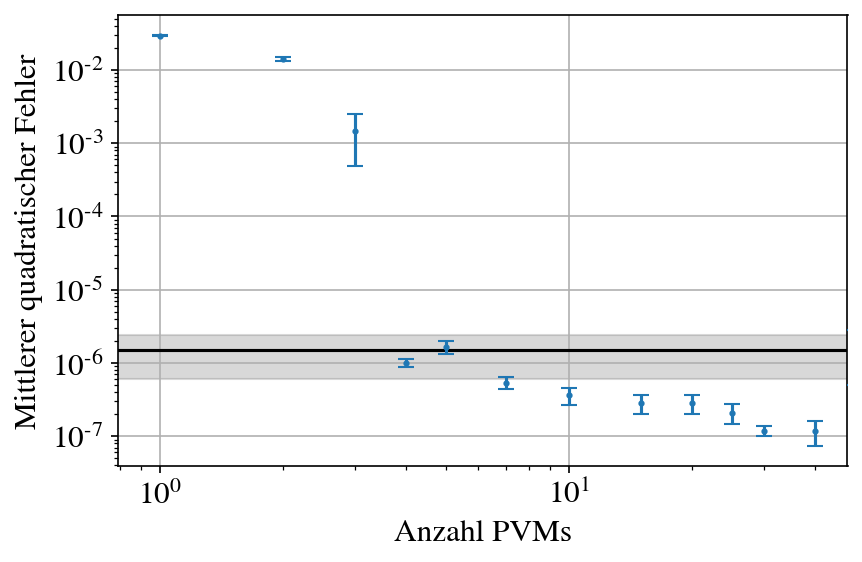

In [100]:
plt.figure(dpi=150)
plt.errorbar(obs_arr, perf_means, yerr=perf_merr, fmt = 'o', markersize = 2, capsize = 4,\
    label='zufällig generierte PVMs', zorder = 10)
plt.plot(np.linspace(0,120,len(obs_arr)), pauli_mean, c='k', label='Pauli PVMs (Vergleich)')
plt.fill_between(np.linspace(0,120,len(obs_arr)), pauli_mean-pauli_merr, pauli_mean + pauli_merr, color='grey', alpha=.3)
plt.xlabel('Anzahl PVMs')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0,48)

#plt.legend()#loc='center left', bbox_to_anchor=(1,0.5))
plt.grid()

<Figure size 900x600 with 0 Axes>

Text(0.5, 0, 'Netzwerk Nr.')

Text(0, 0.5, 'Mittlerer quadratischer Fehler')

(0.75, 10.25)

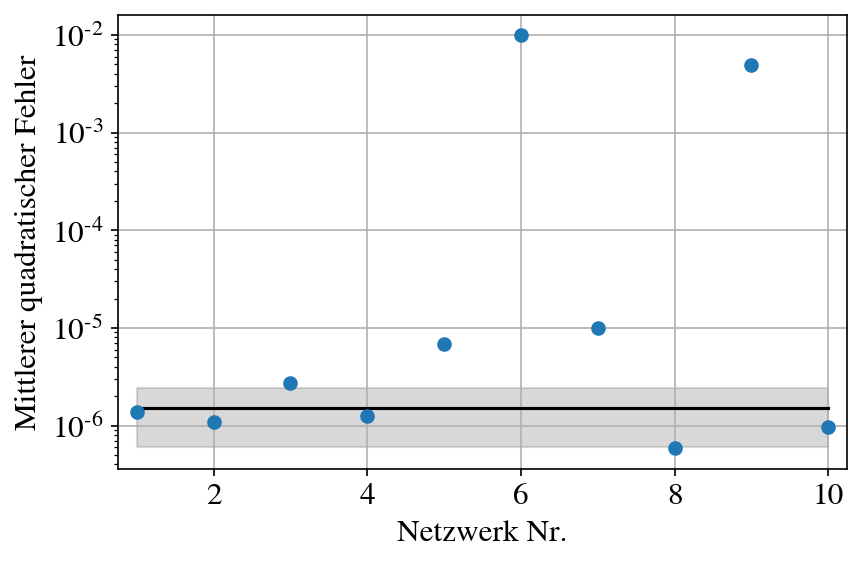

In [53]:
xspace = np.arange(1,len(performances[0])+1)
pauli_mean = np.mean(pauli_performances) * np.ones(len(performances[0]))

plt.figure(dpi=150)
plt.scatter(xspace, performances[0], label='3 zufällige PVMs (einzeln)', zorder=10)
plt.plot(xspace, pauli_mean, c='k', label='3 orthogonale PVMs (gemittelt)')
plt.fill_between(xspace, pauli_mean-pauli_merr, pauli_mean + pauli_merr, color='grey', alpha=.3)
plt.xlabel('Netzwerk Nr.')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.yscale('log')
#plt.legend(loc='center left')
plt.xlim(.75, 10.25)
plt.grid()

0.0

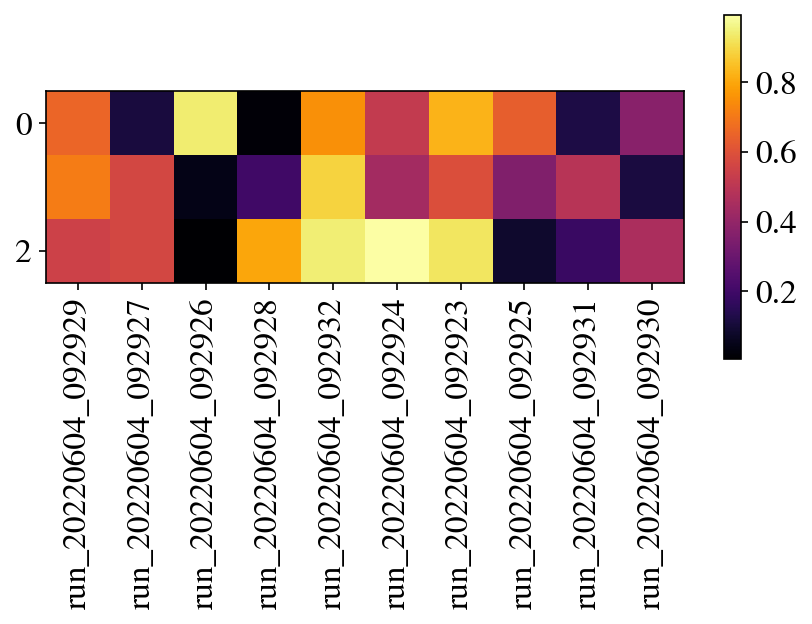

array([['1.3871047030988848e-06', 'run_20220604_092929'],
       ['1.0915621184418948e-06', 'run_20220604_092927'],
       ['2.736081235828654e-06', 'run_20220604_092926'],
       ['1.249678780368413e-06', 'run_20220604_092928'],
       ['6.807515243660116e-06', 'run_20220604_092932'],
       ['0.00994751633455356', 'run_20220604_092924'],
       ['9.949736947116132e-06', 'run_20220604_092923'],
       ['5.90379693221621e-07', 'run_20220604_092925'],
       ['0.004906887623171012', 'run_20220604_092931'],
       ['9.630375984670537e-07', 'run_20220604_092930']], dtype='<U32')

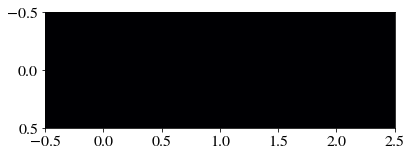

In [ ]:
# Printe observablen der nPVM = 3 messungen

performances, run_names = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10,
                    return_run_names=True) 

def retrieve_observables(data_path, run_directories):
    observables = np.empty((0,3,2,2))
    for rdir in run_directories:
        run_path = data_path + '/' + rdir + '/'
        dim = 2**NQ
        data_obs = np.zeros((0,dim,dim))
        with open(run_path+'/observables.csv', 'r') as f:
            reader = csv.reader(f)
            for line in reader:
                data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))
        observables = np.vstack((observables, [data_obs]))
    return observables, run_directories



observables, run_directories =retrieve_observables('/Users/canrager/thesis/data/tomo0604_1qubit_random_uniform_vector/states10000_obs3',
    run_names)
fidelities = np.array([np.array([np.trace(a.dot(b)), np.trace(c.dot(b)), np.trace(a.dot(c))]) for a,b,c in observables])
np.sum(np.imag(fidelities))
fidelities = np.real(fidelities)

#Colorbar
fig, ax = plt.subplots(dpi=150)
cmap = cm.get_cmap('inferno')
norm = Normalize(vmin=np.min(fidelities), vmax=np.max(fidelities))
colors = cmap(norm(1))
a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
a=sc.set_array([])
a=plt.colorbar(sc)

ax.imshow(fidelities.T,cmap=cmap)
ax.set_xticks(np.arange(10), run_directories, rotation='vertical')
plt.show()

np.vstack((performances.flatten(),run_names)).T

pauli_fidelities = np.real(np.array([[np.trace(s1.dot(s2)), np.trace(s1.dot(s3)), np.trace(s2.dot(s3))]]))

plt.imshow(pauli_fidelities, cmap=cmap)

In [ ]:
a,b,c = observables[0]
np.trace(a.dot(b.dot(c)))
c


(0.45673096515319794+0.21531036005094847j)

array([[0.56389221+0.j        , 0.49432582+0.03949387j],
       [0.49432582-0.03949387j, 0.43610779+0.j        ]])

#### 2 Qubit

In [47]:
performances = evaluate_multiple(dataexp_path='./data/tomo0607_2qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[12,15,20],
                    num_runs=10)
performances

perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

perf_means
perf_merr

perf15 = performances[1]


array([[1.58369978e-03, 1.35102330e-03, 1.20430392e-03, 1.43180644e-03,
        1.54576247e-03, 1.67086592e-03, 1.76550210e-03, 1.27556045e-03,
        1.20513421e-03, 1.23586282e-03],
       [4.31577916e-04, 6.31858129e-04, 3.51149594e-04, 4.37341493e-04,
        1.50610266e-03, 6.73129499e-04, 7.07679013e-04, 5.63480561e-04,
        5.19850024e-04, 8.17448223e-04],
       [1.05879914e-03, 2.38916768e-06, 1.11224736e-06, 5.14172854e-05,
        1.00141921e-04, 3.18334452e-04, 4.15320267e-06, 1.32757545e-05,
        3.30369526e-04, 3.48756245e-07]])

array([0.00142695, 0.00066396, 0.00018803])

array([6.13835874e-05, 9.84814901e-05, 9.95409848e-05])

In [73]:
pauli1q = np.array([np.eye(2), s1, s2, s3])
pauli2q = np.zeros((0, 4, 4))
for a in pauli1q:
    for b in pauli1q:
        pauli2q = np.vstack((pauli2q, [np.kron(a,b)]))

pauli2q_projectors = (np.eye(4) + pauli2q[1:])/2
n_states=10000


In [ ]:
custom_obs_dataset( dataexp_title='tomo_2qubit_PAULI2_projectors',
                    n_states=n_states,
                    observables=pauli2q_projectors,
                    n_runs=10)

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [02:44<00:00, 11.00s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


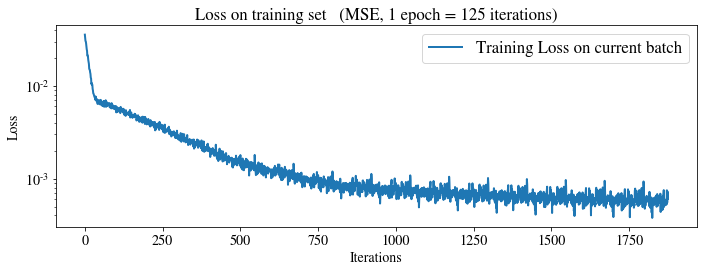

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


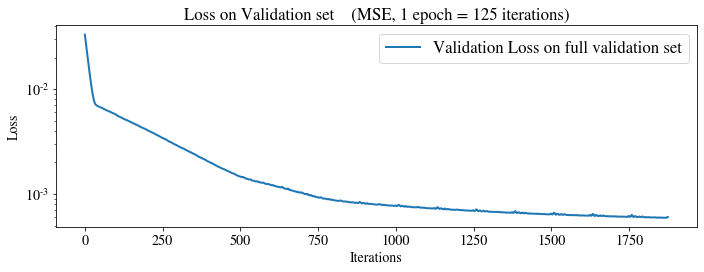

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [02:45<00:00, 11.01s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


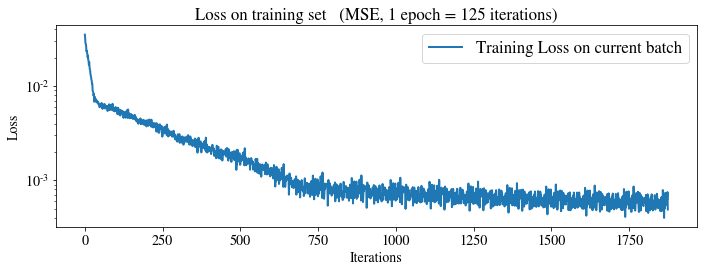

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


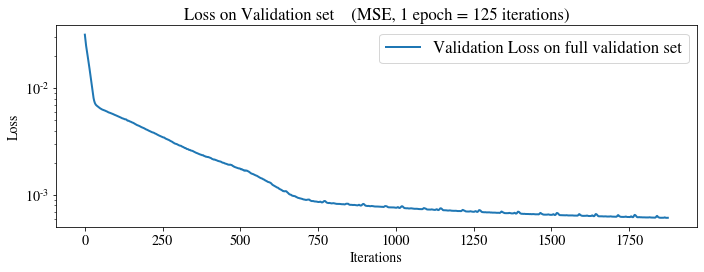

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [02:45<00:00, 11.06s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


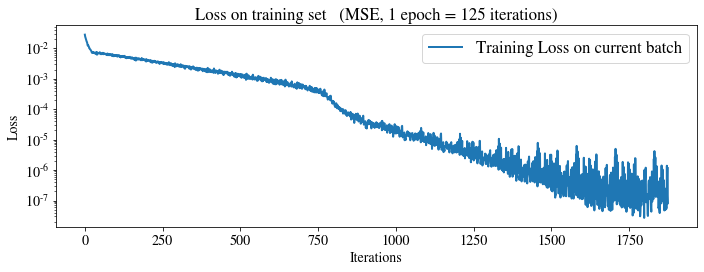

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


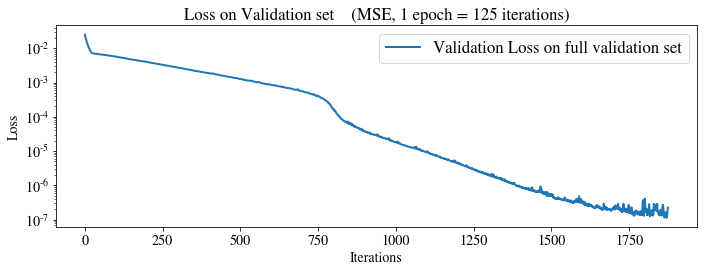

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [02:44<00:00, 10.96s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


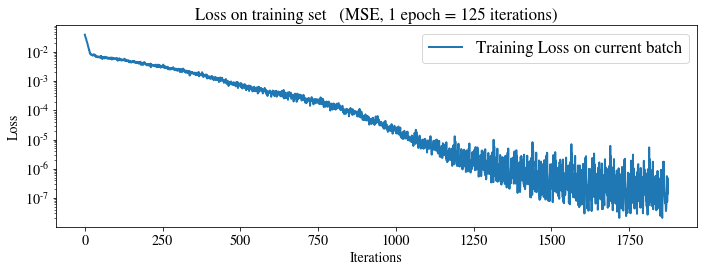

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


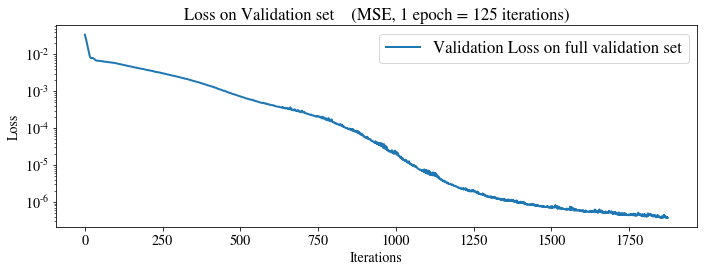

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [02:47<00:00, 11.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


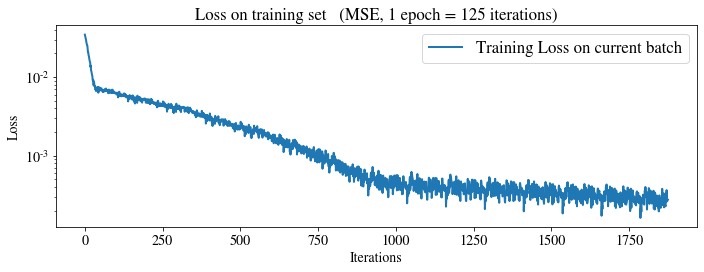

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


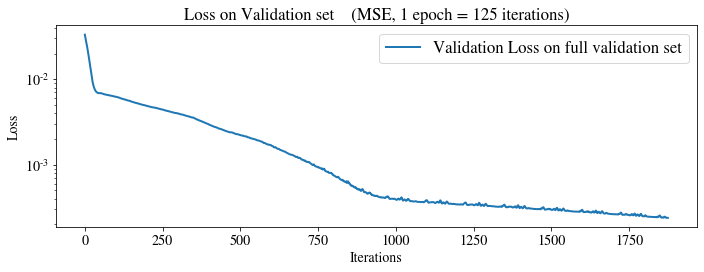

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [46:14<00:00, 184.95s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


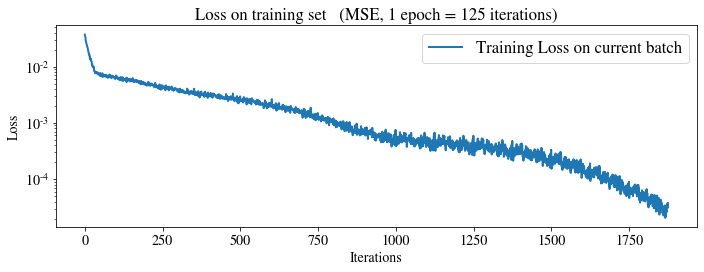

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


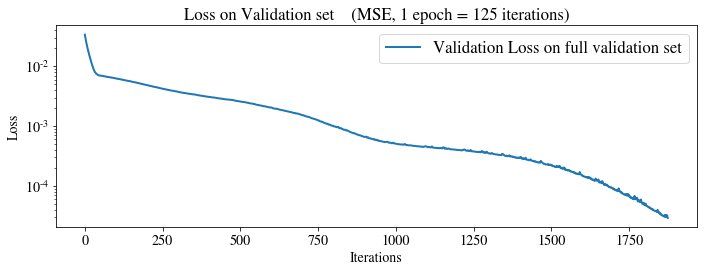

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [02:29<00:00,  9.96s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


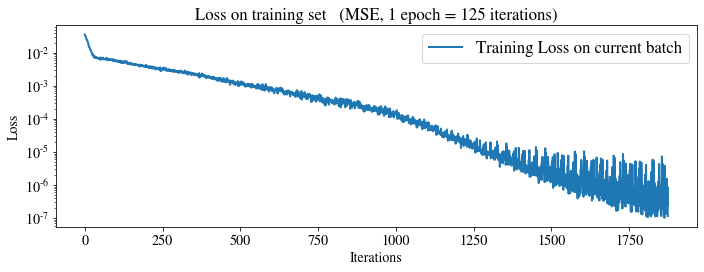

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


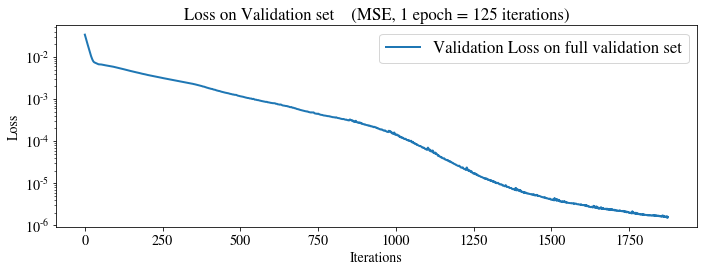

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [01:39<00:00,  6.66s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


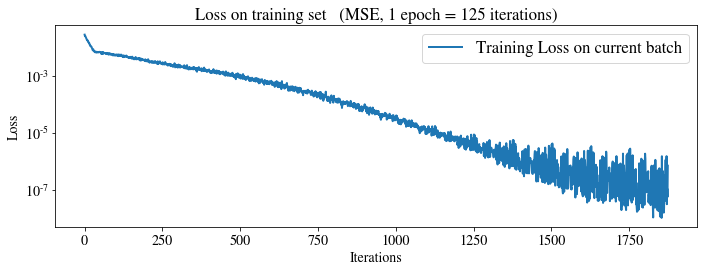

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


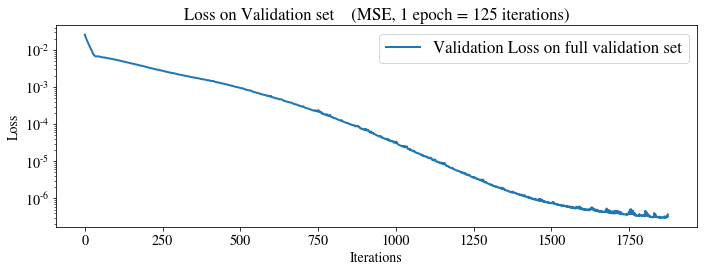

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [01:39<00:00,  6.65s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


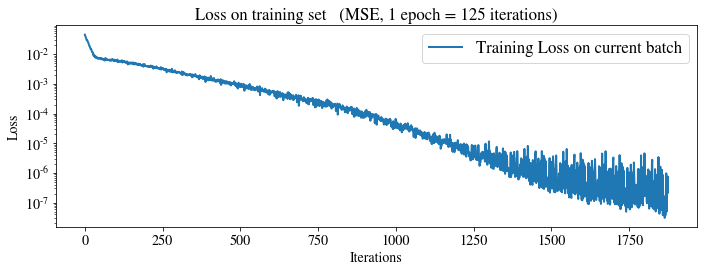

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


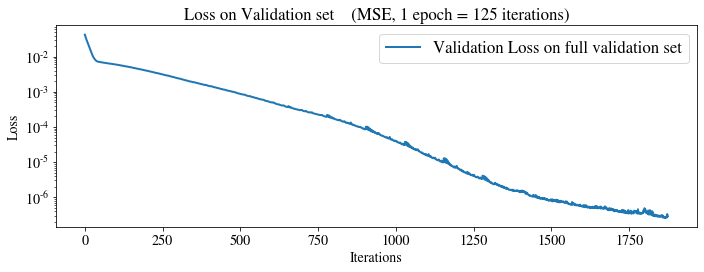

FeedForwardNet(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)


100%|██████████| 15/15 [01:39<00:00,  6.65s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


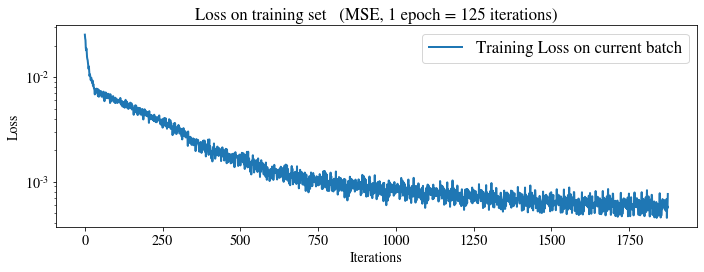

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


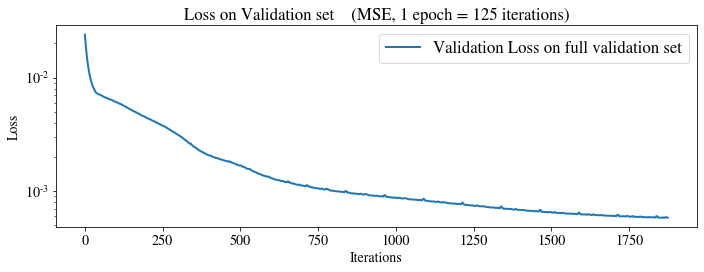

In [75]:
train_multiple_runs(dataexp_path='./data/tomo_2qubit_PAULI2_projectors_2qubit_random_uniform_vector',
                    model_title='2qubit_PAULI2_projectors',
                    nstat=n_states, 
                    obs_arr=[15], 
                    bs=64,
                    lr=1e-3,
                    nepochs=15)

In [ ]:
pauli_performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
                    model_title='2qubit_PAULI2_projectors',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10)
pauli_performances
pauli_mean = np.mean(pauli_performances) * np.ones(len(obs_arr))
pauli_merr = np.std(pauli_performances) / len(pauli_performances)

## Inference

In [44]:
nobs = 3
model_path = './models/FFN_states10000_obs3_epochs15_lr0.001_ConstLatentDimension_run_20220604_092923'
data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs3/run_20220604_092923'

In [45]:
# Load Model
load_net = FeedForwardNet(n_obs=nobs).to(device)
load_net.load_state_dict(torch.load(model_path+'/model.model'))

# Import Observables
dim = 2**NQ
data_obs = np.zeros((0,dim,dim))
with open(data_path+'/observables.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))

<All keys matched successfully>

3it [00:00, 1550.38it/s]


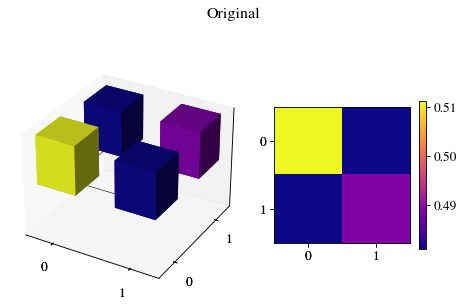

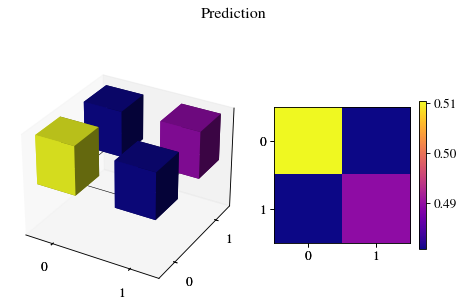

In [53]:
rho_infer = random_rho(pure=False)
m_infer = torch.Tensor(perform_measurements(rho_infer, data_obs))
freeparam_pred = load_net.forward(m_infer.to(device)).detach().cpu().numpy()
rho_pred = torch2rho(freeparam_pred)

plot_dm(np.real(rho_infer), title='Original')
plot_dm(np.real(rho_pred), title='Prediction')

# AE Compact State Representations

## Autoencoder

In [30]:
class AutoencoderNet(nn.Module):

  def __init__(self, latent_dim, measurement_dim):
    super().__init__()

    self.layer1_size = 64
    self.layer2_size = 32

    self.encoder = nn.Sequential(
    nn.Linear(measurement_dim, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, latent_dim),
    )

    self.decoder = nn.Sequential(
    nn.Linear(latent_dim, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, measurement_dim),
    )

  def forward(self, x):
    minrep = self.encoder(x)
    output = self.decoder(minrep)
    return output
  
  def encode(self, x):
    return self.encoder(x)

## Training

In [31]:
def evaluate_mse_ae(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements = batch[0].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, measurements).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [32]:
# Function for training the network
def ae_train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)

            loss = criterion(outputs, data)
            

            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ae(net, valid_dataloader, criterion, device))

    return train_losses, valid_losses

In [33]:
def ae_train_eval(data_dir,
                  model_title,
                  nstat,
                  nobs,
                  latent_size, 
                  learning_rate, 
                  nepochs):

    print(data_dir,
                  model_title,
                  nstat,
                  nobs,
                  latent_size, 
                  learning_rate, 
                  nepochs)

    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)
    train_dataloader, valid_dataloader, treasure_dataloader = load_dataset(data_dir+'/', nstat)

    # Create the network on the CPU/GPU
    ae_net = AutoencoderNet(measurement_dim=nobs, latent_dim=latent_size).to(device)
    print(ae_net)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae_net.parameters(), lr=learning_rate)

    #Do training
    train_losses, valid_losses = ae_train(  ae_net, 
                                            nepochs, 
                                            train_dataloader, 
                                            valid_dataloader, 
                                            optimizer, 
                                            criterion)


    print(train_losses)
    # Log the loss on the unseen set                  
    treasure_loss = evaluate_mse_ae(ae_net, treasure_dataloader, criterion, device)

    # Save Model
    path = f'./models/AE_states{int(nstat)}_obs{nobs}_latentdim{latent_size}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(ae_net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(train_dataloader), path=path)

    return treasure_loss


In [34]:
def ae_train_multiple_runs(data_path, model_title, latent_dims, nstat, nobs, lr, nepochs):
    performances = np.array([])

    run_directories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    for rdir in run_directories:
        run_path = data_path + '/' + rdir + '/'
        run_perf = np.array([])
        for ldim in latent_dims:
            perf = ae_train_eval(data_dir=run_path,
                            model_title=model_title,
                            nstat=nstat,
                            nobs=nobs,
                            latent_size=ldim, 
                            learning_rate=lr, 
                            nepochs=nepochs)
            print(perf)
            run_perf = np.append(run_perf, perf)
        performances = np.append(performances, run_perf)
    return performances

In [59]:
# ae_perf = ae_train_multiple_runs(data_path='./data/tomo0604_1qubit_random_uniform_vector/states10000_obs100',
#                                     model_title='FindMinDim', 
#                                     latent_dims=[0,1,2,3,4,5,7,9,11], 
#                                     nstat=1e4, 
#                                     nobs=100, 
#                                     lr=1e-3, 
#                                     nepochs=20)

### 2 Qubit training

In [43]:
1500/125

12.0

./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 15 0.001 20
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 20/20 [03:59<00:00, 11.99s/it]


[0.08345665 0.08090486 0.07896098 ... 0.00074581 0.00072803 0.00086037]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


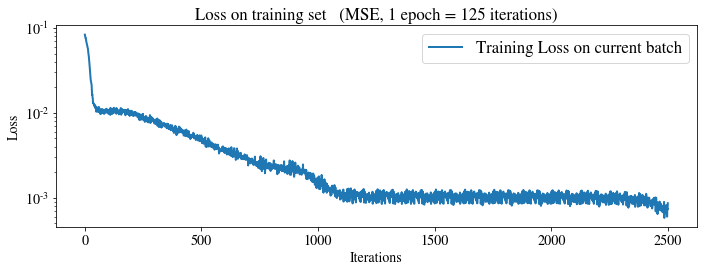

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_32910/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


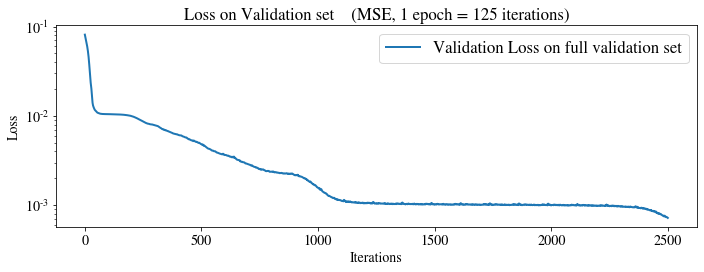

0.0007074215488197902
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 15 0.001 20
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


  0%|          | 0/20 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [41]:
ae_perf = ae_train_multiple_runs(data_path='./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100',
                                    model_title='2qubit_FindMinDim', 
                                    latent_dims=[15], 
                                    nstat=1e4, 
                                    nobs=100, 
                                    lr=1e-3, 
                                    nepochs=12)

## Evaluation

In [114]:
def ae_eval_multiple_runs(dataexp_path, model_title, latent_dims, nstat, nobs, nruns):
    performances = np.empty((0, nruns))

    all_model_paths = [f for f in os.listdir('./models') if model_title in f]
    for ldim in latent_dims:
        ldim_perf = np.array([])
        ldim_model_paths = [f for f in all_model_paths if f'latentdim{ldim}_' in f][:nruns]
        print(f'{len(ldim_model_paths)} trained {model_title} models found with latent dim = {ldim}.')
        for run in ldim_model_paths:
            model_path = './models/' + run
            run_name = re.search('([^(run)]+$)', model_path).group(0)
            data_run_path = dataexp_path + f'/states{int(nstat)}_obs{nobs}/run{run_name}/'
            _, _, treasure_dataloader = load_dataset(data_run_path, nstat)

            loaded_model = AutoencoderNet(measurement_dim=nobs, latent_dim=ldim).to(device)
            loaded_model.load_state_dict(torch.load(model_path+'/model.model'))
            treasure_mse = evaluate_mse_ae(loaded_model, treasure_dataloader, nn.MSELoss(), device)
            ldim_perf = np.append(ldim_perf, treasure_mse)
        performances = np.vstack((performances, ldim_perf))

    ldim_means = np.mean(performances, axis=1)
    ldim_merrs = np.std(performances, axis=1) / np.sqrt(nruns)
    plt.figure(dpi=150)
    plt.errorbar(latent_dims, ldim_means, yerr=ldim_merrs, fmt='o', markersize = 2, capsize = 4)
    plt.xlabel('Dimension des latenten Vekors')
    plt.ylabel('Mittlerer quadratischer Fehler')
    plt.yscale('log')
    plt.grid()
    return performances

In [ ]:
print(ae_perf)

[0.04702447]


## Latent Representation Bloch?

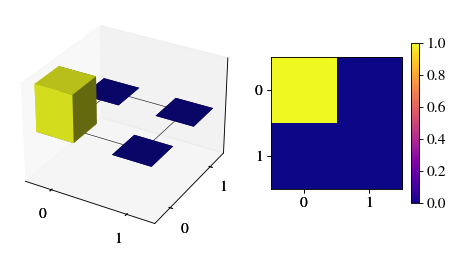

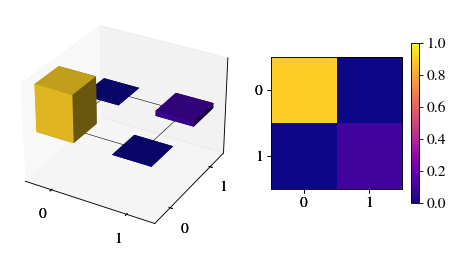

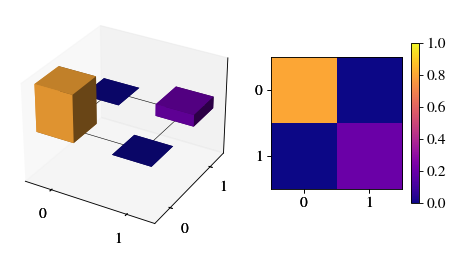

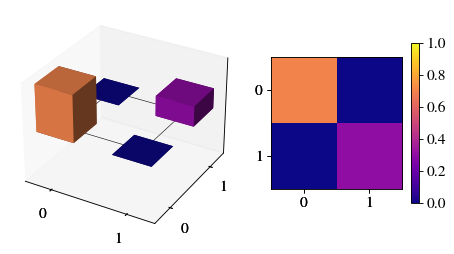

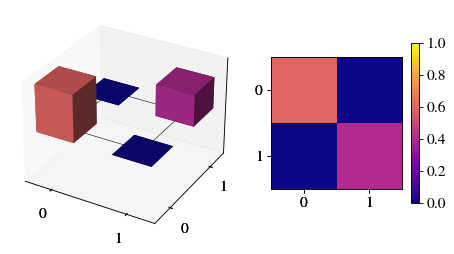

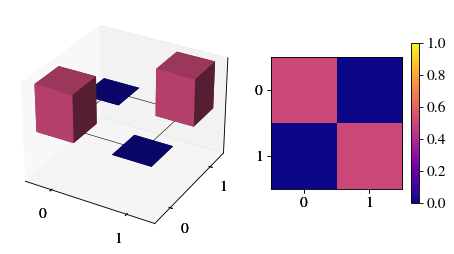

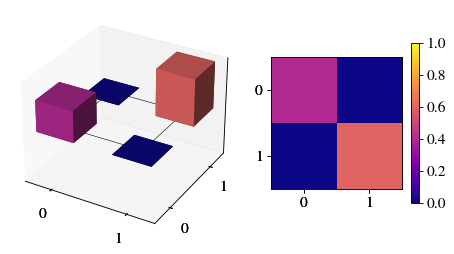

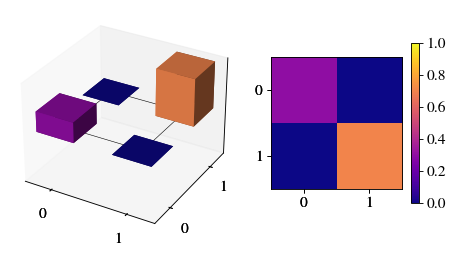

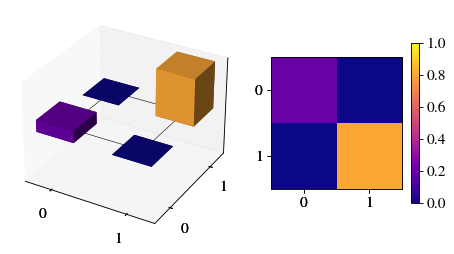

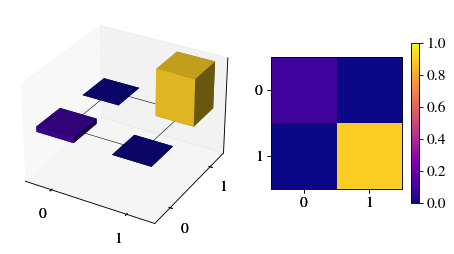

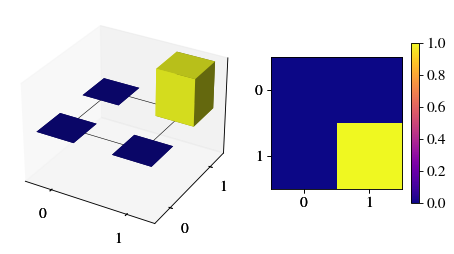

In [179]:
tspace = np.arange(11)/10
P_plus = np.array([[1,0], [0,0]])
P_minus = np.array([[0,0], [0,1]])
P_tseries = [(1-t) * P_plus + t * P_minus for t in tspace]

for Pt in P_tseries: 
    plot_dm(np.real(Pt), fixed_scale=(0,1))

In [180]:
def ae_encode_inference(rho, model_path, data_path, nobs):
    # Load observables
    dim = 2**NQ
    data_obs = np.zeros((0,dim,dim))
    with open(data_path+'/observables.csv', 'r') as f:
        reader = csv.reader(f)
        for line in tqdm(reader):
            data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))

    # Make measurements on state
    m_infer = torch.Tensor(perform_measurements(rho, data_obs))

    # Load Model
    load_net = AutoencoderNet(measurement_dim=nobs, latent_dim=3).to(device)
    load_net.load_state_dict(torch.load(model_path+'/model.model'))

    # Encode measurements with ae
    bloch_rep = load_net.encode(m_infer).detach().cpu().numpy()
    rho_encoded = torch2rho(bloch_rep)
    return rho_encoded

100it [00:00, 37981.56it/s]
100it [00:00, 38360.20it/s]
100it [00:00, 46101.38it/s]
100it [00:00, 42551.53it/s]
100it [00:00, 36061.42it/s]
100it [00:00, 37365.74it/s]
100it [00:00, 30535.12it/s]
100it [00:00, 41185.23it/s]
100it [00:00, 36602.71it/s]
100it [00:00, 29770.06it/s]
100it [00:00, 26781.84it/s]


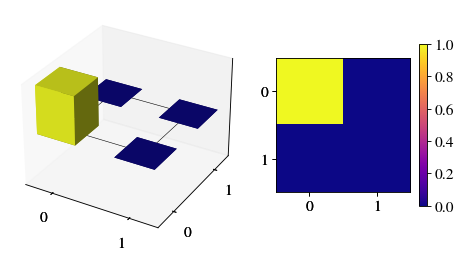

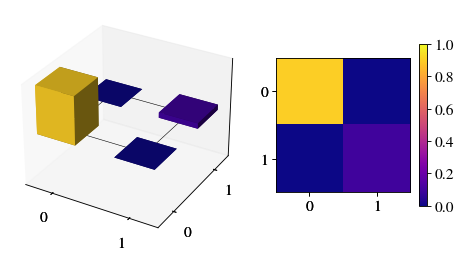

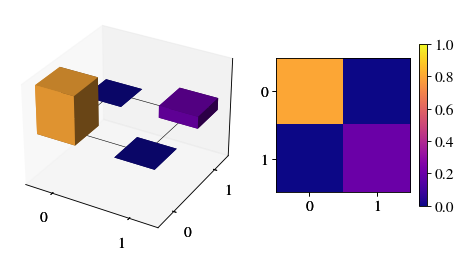

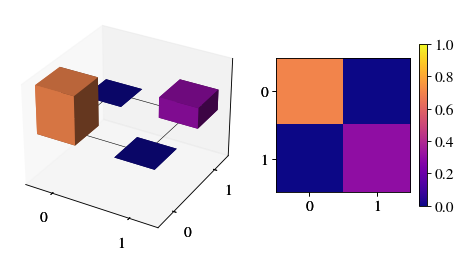

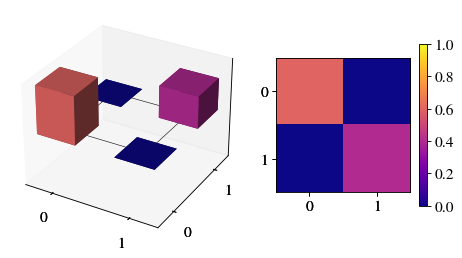

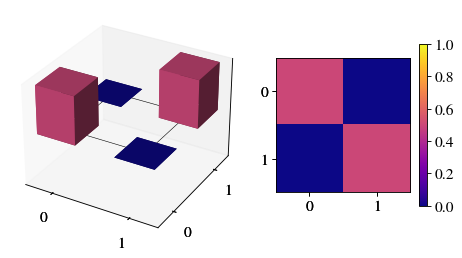

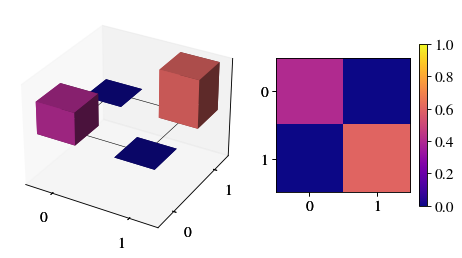

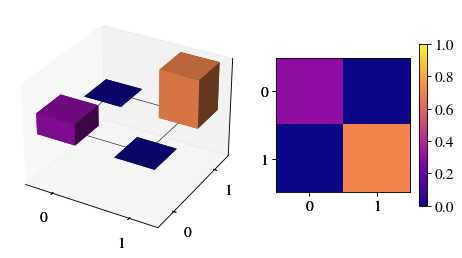

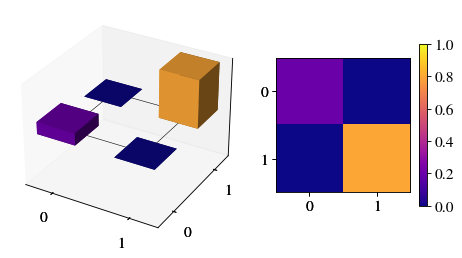

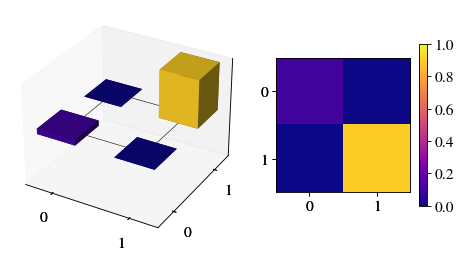

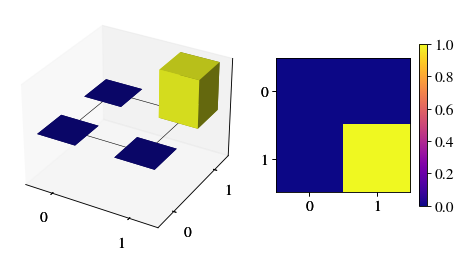

In [185]:
# ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092852'
# ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092852'

# ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092841'
# ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092841'

ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092837'
ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092837'

Encoded_tseries = [ae_encode_inference(rho_infer, ae_test_model_path, ae_test_data_path, nobs=100) for rho_infer in P_tseries]
Encoded_tseries = np.real(Encoded_tseries)


for i, (rho_infer, rho_encoded) in enumerate(zip(P_tseries, Encoded_tseries)):
    plot_dm(np.real(rho_infer),
            save_path = f'./results/rep_series/Ptseries/{i}.png', fixed_scale=(np.min(P_tseries), np.max(P_tseries)))
    # plot_dm(np.real(rho_encoded), title='', save_path=f'./results/rep_series/enc37series/{i}.png', fixed_scale=(np.min(Encoded_tseries), np.max(Encoded_tseries)))
